## Human Activity Recognition System using Machine Learning techniques for Home Automation by Leon Vitanos

Dataset used: https://tev.fbk.eu/technologies/smartwatch-gestures-dataset

Eight different users performed twenty repetitions of twenty different gestures, for a total of 3200 sequences. Each sequence contains acceleration data from the 3-axis accelerometer of a first generation Sony SmartWatch™, as well as timestamps from the different clock sources available on an Android device. The smartwatch was worn on the user's right wrist. The gestures have been manually segmented by the users performing them by tapping the smartwatch screen at the beginning and at the end of every repetition.

<img src="https://i.imgur.com/U3Uqe9x.png">



In [1]:
import yaml
from utils.dotdict import dotdict

with open('settings.yaml', 'r') as f:
    settings = dotdict(yaml.load(f, Loader=yaml.Loader))


### Load and preprocess dataset
We use the first 8 Haar transformation coefficients for each axis, creating a 24 vector for each sequence

In [3]:
import numpy as np
import pandas as pd
import os
import pywt

print("Loading and preprocessing dataset...")
training_data_all_gestures = []
training_data_six_gestures = []


def haar_transform(sequence_array):
    x = np.concatenate(
        (pywt.wavedec(sequence_array.iloc[:, 0], settings.wavelet_name, level=3)))
    y = np.concatenate(
        (pywt.wavedec(sequence_array.iloc[:, 1], settings.wavelet_name, level=3)))
    z = np.concatenate(
        (pywt.wavedec(sequence_array.iloc[:, 2], settings.wavelet_name, level=3)))
    xyz = np.concatenate((x[:8], y[:8], z[:8]))
    return xyz


for user in settings.users:
    user_path = os.path.join(settings.dataset.path, user)
    for gesture in settings.gestures:
        class_num = settings.gestures.index(gesture)
        path = os.path.join(user_path, gesture)
        for sequence in os.listdir(path):
            sequence_array = pd.read_csv(os.path.join(path, sequence),
                                         sep=" ", header=None, usecols=[3, 4, 5])
            training_data_all_gestures.append([haar_transform(sequence_array),
                                               class_num])
            if class_num <= 5:
                training_data_six_gestures.append([haar_transform(sequence_array),
                                                   class_num])

print("In total", len(training_data_all_gestures),
      "sequences have been loaded and preprocessed")


Loading and preprocessing dataset...
In total 3251 sequences have been loaded and preprocessed


### Split training (6 users) / test set (2 users)

In [4]:
# For all gestures
X, y, X6, y6 = ([] for _ in range(4))

for features, label in training_data_all_gestures:
    X.append(features)
    y.append(label)

for features, label in training_data_six_gestures:
    X6.append(features)
    y6.append(label)
    
split_point = settings.dataset.split_point
split_point_6 = settings.dataset.split_point_6

X_train, X_test = X[:split_point], X[split_point + 1:]
y_train, y_test = y[:split_point], y[split_point + 1:]

X6_train, X6_test = X6[:split_point_6], X6[split_point_6 + 1:]
y6_train, y6_test = y6[:split_point_6], y6[split_point_6 + 1:]


## Find best algorithm
Between the following:
- K-nearest neighbors (KNN) 
- Decision Tree (DT)
- Random Forest (RF)
- Support Vector Machines (SVM)
- Multilayer perceptron (MLP)
- Convolutional neural network (CNN)
- Recurrent neural networks (RNN) using long-short term memory (LSTM)

### Helper functions, to predict and print results

In [3]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

#8 Classifiers
best_accuracy, best_accuracy6 = [0]*8, [0]*8

def predict_accuracy_and_f1():
    #scores = cross_val_score(model, X_train, y_train, cv=10)
    #accVal.append(scores.mean())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    accTest.append(acc)
    f1 = metrics.f1_score(y_test, y_pred, average="macro", labels=np.unique(y_pred))
    f1Test.append(f1)
    
    #scores6 = cross_val_score(model6, X6_train, y6_train, cv=6)
    #accVal6.append(scores6.mean())
    model6.fit(X6_train, y6_train)
    y_pred = model6.predict(X6_test)
    acc = metrics.accuracy_score(y6_test, y_pred)
    accTest6.append(acc)
    f1 = metrics.f1_score(y6_test, y_pred, average="macro", labels=np.unique(y_pred))
    f1Test6.append(f1)
       
def print_and_plot_results(model, argument, num):
    #max_val_index = accVal.index(max(accVal))
    #max_val6_index = accVal6.index(max(accVal6))
    max_val_index = accTest.index(max(accTest))
    max_val6_index = accTest6.index(max(accTest6))
    max_acc = accTest[max_val_index]
    max_acc6 = accTest6[max_val6_index]
    best_accuracy[num]=max_acc
    best_accuracy6[num]=max_acc6
    
    plt.figure(figsize=(14,6))
    
    plt.subplot(2, 2, 1)
    plt.plot(lnS,f1Test6, label="Using the first 6 gestures")
    plt.plot(lnS,f1Test, label="Using all gestures")
    plt.title("F1 Macro")
    plt.ylabel("F1 Macro")
    plt.xlabel(argument)
    plt.legend(loc='lower right')
    
    plt.subplot(2, 2, 3)
    plt.plot(lnS,accTest6, label="Using the first 6 gestures")
    plt.plot(lnS,accTest, label="Using all gestures")
    plt.title("Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel(argument)
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    y_pred = model.predict(X6_test)
    cm = confusion_matrix(y6_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=range(1, 7), columns=range(1, 7),)
    heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), 
                                 rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), 
                                 rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix using 6 gestures\n and %s set to %d " 
              % (argument,lnS[max_val6_index]))
    
    plt.tight_layout(pad=0.4, w_pad=3, h_pad=1)
    plt.show()  
    
    print("Max accuracy is {:.3f},".format(max_acc),"with F1 score {:.3f},".format(f1Test[max_val_index]),
      "using all gestures and",argument,"set to",lnS[max_val_index],end=".\n")
    print("Max accuracy is {:.3f},".format(max_acc6),"with F1 score {:.3f},".format(f1Test6[max_val6_index]),
      "using 6 gestures and",argument,"set to",lnS[max_val6_index],end=".")

### K-nearest neighbors (KNN)

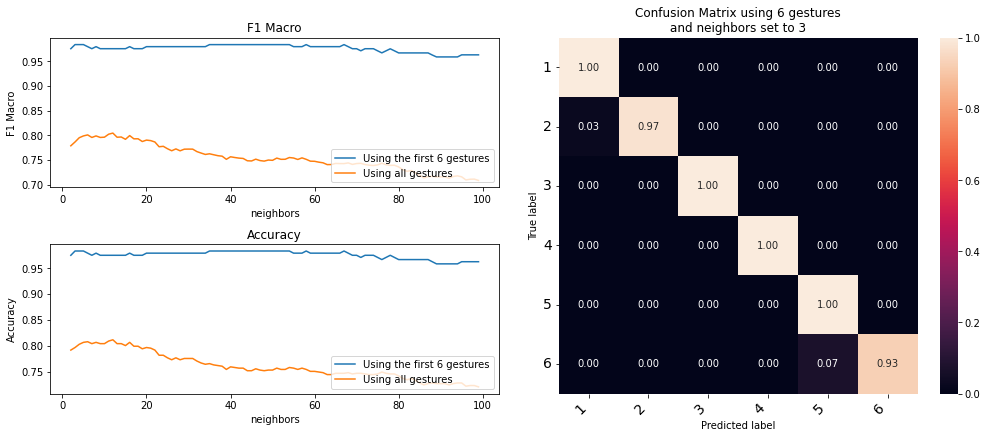

Max accuracy is 0.811, with F1 score 0.804, using all gestures and neighbors set to 12.
Max accuracy is 0.983, with F1 score 0.983, using 6 gestures and neighbors set to 3.

In [4]:
from sklearn.neighbors import KNeighborsClassifier

accTest, accVal, accTest6, accVal6, f1Test, f1Test6, lnS = ([] for i in range(7))

for ln in range(2,100):
    lnS.append(ln)
    model = KNeighborsClassifier(n_neighbors=ln, weights='distance')
    model6 = KNeighborsClassifier(n_neighbors=ln, weights='distance')
    predict_accuracy_and_f1()

best_n_neighbors=lnS[accTest6.index(max(accTest6))]    
model = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights='distance')
model.fit(X6_train, y6_train)
print_and_plot_results(model,"neighbors", 0)

### Decision Tree (DT)

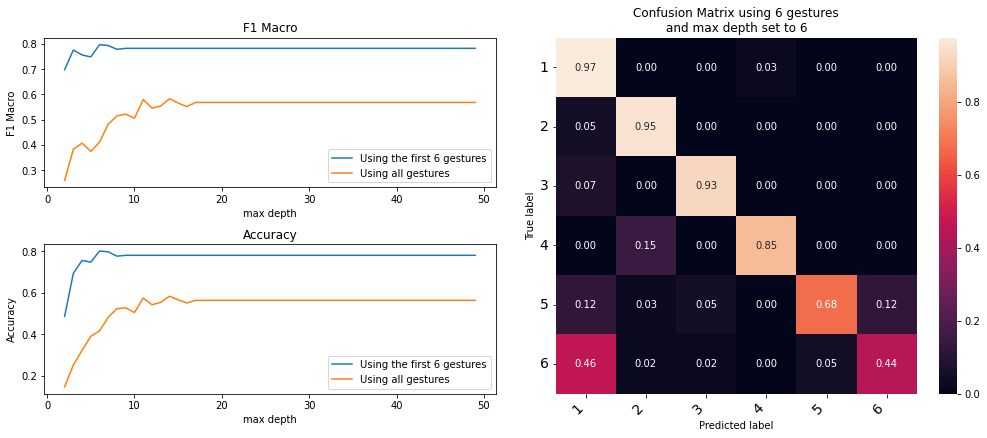

Max accuracy is 0.583, with F1 score 0.583, using all gestures and max depth set to 14.
Max accuracy is 0.801, with F1 score 0.797, using 6 gestures and max depth set to 6.

In [5]:
from sklearn.tree import DecisionTreeClassifier

accTest, accVal, accTest6, accVal6, f1Test, f1Test6, lnS = ([] for i in range(7))

for ln in range(2,50):
    lnS.append(ln)
    model = DecisionTreeClassifier(max_depth=ln, random_state=0)
    model6 = DecisionTreeClassifier(max_depth=ln, random_state=0)
    predict_accuracy_and_f1()

best_max_depth=lnS[accTest6.index(max(accTest6))]
model = DecisionTreeClassifier(max_depth=best_max_depth, random_state=0)
model.fit(X6_train, y6_train)
print_and_plot_results(model,"max depth", 1)

### Random Forest (RF)

100%|██████████| 12/12 [00:41<00:00,  3.44s/it]


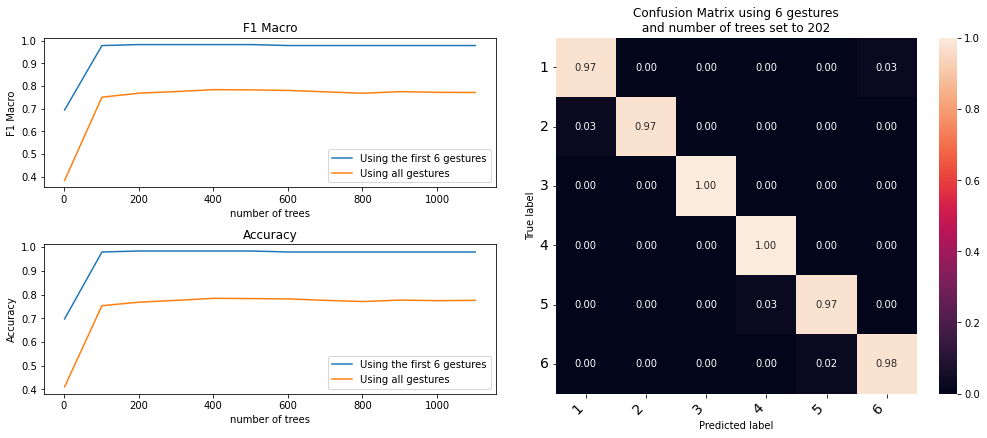

Max accuracy is 0.784, with F1 score 0.784, using all gestures and number of trees set to 402.
Max accuracy is 0.983, with F1 score 0.983, using 6 gestures and number of trees set to 202.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

accTest, accVal, accTest6, accVal6, f1Test, f1Test6, lnS = ([] for i in range(7))

for ln in tqdm(range(2, 1200, 100)):
    lnS.append(ln)
    model = RandomForestClassifier(n_estimators=ln, random_state=0)
    model6 = RandomForestClassifier(n_estimators=ln, random_state=0)
    predict_accuracy_and_f1()

best_n_estimators=lnS[accTest6.index(max(accTest6))]
model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=0)
model.fit(X6_train, y6_train)
print_and_plot_results(model,"number of trees", 2)


### Support Vector Machines (SVM)

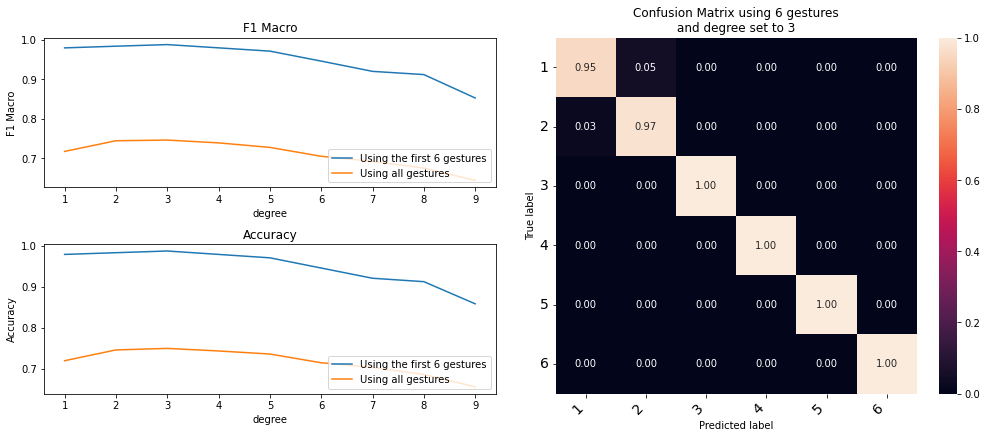

Max accuracy is 0.750, with F1 score 0.746, using all gestures and degree set to 3.
Max accuracy is 0.988, with F1 score 0.987, using 6 gestures and degree set to 3.

In [7]:
from sklearn.svm import SVC

accTest, accVal, accTest6, accVal6, f1Test, f1Test6, lnS = ([] for i in range(7))

for ln in range(1,10):
    lnS.append(ln)
    model = SVC(kernel='poly', gamma='scale', degree=ln, random_state=0)
    model6 = SVC(kernel='poly', gamma='scale', degree=ln, random_state=0)
    predict_accuracy_and_f1()

best_degree=lnS[accTest6.index(max(accTest6))]
model = SVC(kernel='poly', gamma='scale', degree=best_degree,random_state=0)
model.fit(X6_train, y6_train)
print_and_plot_results(model,"degree", 3)

## Deep Learning

In [8]:
import warnings
# from sklearn.exceptions import ConvergenceWarning
# from sklearn.utils.testing import ignore_warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def prepare_data(reshaped):
    global xTr, yTr, xTe, yTe, xVal, yVal, x6Tr, y6Tr, x6Te, y6Te, x6Val, y6Val
    
    if reshaped: # For CNN and LSTM
        xTr, yTr, xTe, yTe, xVal, yVal = x_tr_re, y_tr_re, x_te_re, y_te_re, x_val_re, y_val_re
        x6Tr, y6Tr, x6Te, y6Te, x6Val, y6Val = x6_tr_re, y6_tr_re, x6_te_re, y6_te_re, x6_val_re, y6_val_re
    else: # For MLP
        xTr, yTr, xTe, yTe, xVal, yVal = np.copy(x_tr), y_tr, x_te, y_te, x_val, y_val
        x6Tr, y6Tr, x6Te, y6Te, x6Val, y6Val = x6_tr, y6_tr, x6_te, y6_te, x6_val, y6_val

#Fit data and predict accuracy
def predict_accuracy(model, model6):   
    model.fit(xTr, yTr, validation_data=(xVal, yVal), epochs=1000,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=0)], 
                        batch_size=batch_size, verbose=0)
    _, test_acc = model.evaluate(xTe, yTe, batch_size=batch_size, verbose=0)

    model6.fit(x6Tr, y6Tr, validation_data=(x6Val, y6Val), epochs=1000,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=0)],
                      batch_size=batch_size, verbose=0)
    _, test_acc6 = model6.evaluate(x6Te, y6Te, batch_size=batch_size, verbose=0)

    accTest.append(test_acc)
    accTest6.append(test_acc6)

# Print and plot results
def print_and_plot_results_neural_network():  
    plt.plot(lnS,accTest6, label="Using the first 6 gestures", marker='o')
    plt.plot(lnS,accTest, label="Using all gestures", marker='o')
    plt.title("Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel('neurons')
    plt.legend(loc='lower right')
    plt.show()
    
    print("Max accuracy is {:.3f},".format(max(accTest)), "using all gestures and",
          "neurons set to",lnS[accTest.index(max(accTest))],end=".\n")
    print("Max accuracy is {:.3f},".format(max(accTest6)), "using 6 gestures and",
          "neurons set to",lnS[accTest6.index(max(accTest6))],end=".")
    
# Train model with the optimal number of neurons and plot it's history
def train_best_model(model, model6, neurons, neurons6):
    #Fit data and find accuracy
    print("Training the model with the optimal number of neurons using all gestures...")
    history = model.fit(xTr, yTr, validation_data=(xVal, yVal), epochs=1000,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1)], 
                    batch_size=batch_size, verbose=0)
    _, test_acc = model.evaluate(xTe, yTe, batch_size=batch_size, verbose=1)

    print("Training the model with the optimal number of neurons using 6 gestures....")
    history6 = model6.fit(x6Tr, y6Tr, validation_data=(x6Val, y6Val), epochs=1000,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1)],
                      batch_size=batch_size, verbose=0)
    _, test_acc6 = model6.evaluate(x6Te, y6Te, batch_size=batch_size, verbose=1)
            
    #Plot accuracy per epoch
    plt.plot(history.history['val_accuracy'], label='Using all gestures')
    plt.plot(history6.history['val_accuracy'], label='Using 6 gestures')
    plt.title("Accuracy of model with the optimal number of neurons")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(loc='lower right')
    plt.show()
        
    #Print accuracy for both models, and model summary for the model with all gestures
    print("Accuracy is {:.3f},".format(test_acc), "using all gestures and",
          "neurons set to",neurons)
    print("Accuracy is {:.3f},".format(test_acc6), "using 6 gestures and",
          "neurons set to",neurons6)
    print("\nModel summary:")
    model.summary()
    
#Split train/test/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X6_train, X6_val, y6_train, y6_val = train_test_split(X6_train, y6_train, test_size=0.2, random_state=1)
    
#Convert data lists to np arrays
x_tr, y_tr, x_te, y_te  = np.asarray(X_train), np.asarray(y_train), np.asarray(X_test), np.asarray(y_test)
x6_tr, y6_tr, x6_te, y6_te = np.asarray(X6_train), np.asarray(y6_train), np.asarray(X6_test), np.asarray(y6_test)
x_val, y_val, x6_val, y6_val = np.asarray(X_val), np.asarray(y_val), np.asarray(X6_val), np.asarray(y6_val)

#Reshaped data, for convolution and lstm
x_tr_re, y_tr_re = x_tr.reshape(x_tr.shape + (1,)), y_tr.reshape(y_tr.shape + (1,))
x_te_re, y_te_re = x_te.reshape(x_te.shape + (1,)), y_te.reshape(y_te.shape + (1,))
x_val_re, y_val_re = x_val.reshape(x_val.shape + (1,)), y_val.reshape(y_val.shape + (1,))
x6_tr_re, y6_tr_re = x6_tr.reshape(x6_tr.shape + (1,)), y6_tr.reshape(y6_tr.shape + (1,))
x6_te_re, y6_te_re = x6_te.reshape(x6_te.shape + (1,)), y6_te.reshape(y6_te.shape + (1,))
x6_val_re, y6_val_re = x6_val.reshape(x6_val.shape + (1,)), y6_val.reshape(y6_val.shape + (1,))
global xTr, yTr, xTe, yTe, xVal, yVal, x6Tr, y6Tr, x6Te, y6Te, x6Val, y6Val


### Multilayer perceptron (MLP)

### MLP Classifier using Sklearn

100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


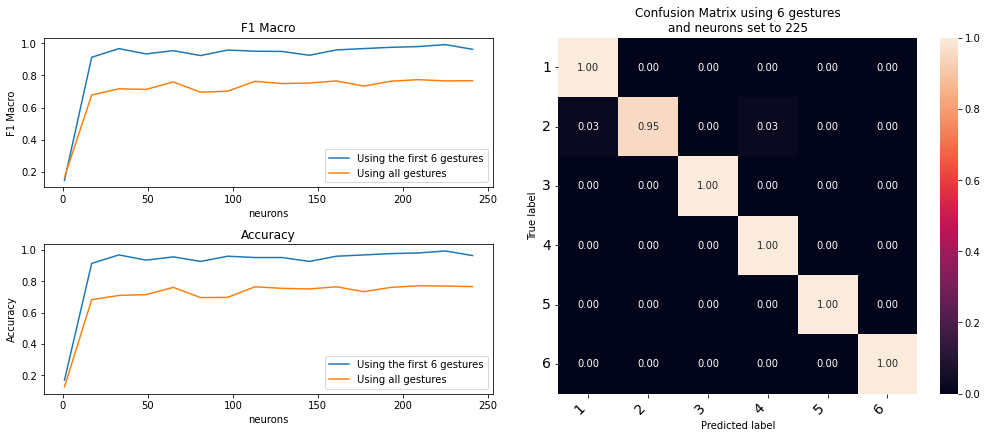

Max accuracy is 0.770, with F1 score 0.774, using all gestures and neurons set to 209.
Max accuracy is 0.992, with F1 score 0.992, using 6 gestures and neurons set to 225.

In [9]:
from sklearn.neural_network import MLPClassifier

accTest, accTest6, f1Test, f1Test6, lnS = ([] for i in range(5))

for ln in tqdm(range(1,256,16)):
    lnS.append(ln)
    model = MLPClassifier(hidden_layer_sizes=(ln,ln), random_state=0)
    model6 = MLPClassifier(hidden_layer_sizes=(ln,ln), random_state=0)
    predict_accuracy_and_f1()

best_n_neurons=lnS[accTest6.index(max(accTest6))]
model = MLPClassifier(hidden_layer_sizes=(best_n_neurons,best_n_neurons), 
                      random_state=0)
model.fit(X6_train, y6_train)
print_and_plot_results(model, "neurons", 4)

### MLP Classifier using Keras

Training for 32 neurons...


2021-10-12 21:42:22.236368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 21:42:22.241002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 21:42:22.241363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 21:42:22.242107: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Accuracy using all gestures: 0.6728 (+/- 0.0479)
Accuracy using 6 gestures: 0.9332 (+/- 0.0435)
Training for 64 neurons...
Accuracy using all gestures: 0.7282 (+/- 0.0388)
Accuracy using 6 gestures: 0.9419 (+/- 0.0431)
Training for 100 neurons...
Accuracy using all gestures: 0.7722 (+/- 0.0280)
Accuracy using 6 gestures: 0.9519 (+/- 0.0238)
Training for 128 neurons...
Accuracy using all gestures: 0.7754 (+/- 0.0428)
Accuracy using 6 gestures: 0.9539 (+/- 0.0271)
Training for 200 neurons...
Accuracy using all gestures: 0.7946 (+/- 0.0363)
Accuracy using 6 gestures: 0.9618 (+/- 0.0296)
Training for 256 neurons...
Accuracy using all gestures: 0.7971 (+/- 0.0226)
Accuracy using 6 gestures: 0.9647 (+/- 0.0197)
Training for 400 neurons...
Accuracy using all gestures: 0.7980 (+/- 0.0254)
Accuracy using 6 gestures: 0.9643 (+/- 0.0204)
Training for 512 neurons...
Accuracy using all gestures: 0.8011 (+/- 0.0151)
Accuracy using 6 gestures: 0.9618 (+/- 0.0189)
Training for 1024 neurons...
Accuracy

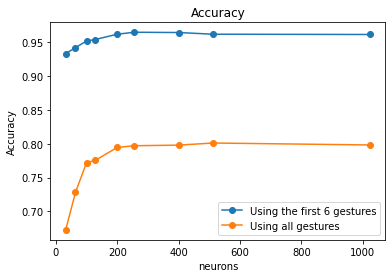

Max accuracy is 0.801, using all gestures and neurons set to 512.
Max accuracy is 0.965, using 6 gestures and neurons set to 256.

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
from keras.callbacks import EarlyStopping
from keras.constraints import max_norm
from keras import backend as K

batch_size=128
accTest, accTest6, lnS = ([] for i in range(3))

def create_mlp_model(ln, output_n_neurons):
    model = Sequential()
    model.add(Dense(ln, kernel_constraint=max_norm(3.), 
                    activation='relu', input_dim=24))
    model.add(Dropout(0.3))
    model.add(Dense(ln, kernel_constraint=max_norm(3.), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(output_n_neurons, kernel_constraint=max_norm(3.), 
                    activation='softmax'))
    model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

n_params = [32, 64, 128, 256, 512, 1024]
accMean, accMean6 = [], []
prepare_data(0)

for p in n_params:
    accTest, accTest6 = [], []
    print("Training for", p, "neurons...")
    
    for r in range(10):
        model = create_mlp_model(p, 20)
        model6 = create_mlp_model(p, 6)
        predict_accuracy(model,model6)
        K.clear_session()
        
    print("Accuracy using all gestures: %0.4f (+/- %0.4f)" 
              % (np.asarray(accTest).mean(), np.asarray(accTest).std() * 2))
    print("Accuracy using 6 gestures: %0.4f (+/- %0.4f)" 
          % (np.asarray(accTest6).mean(), np.asarray(accTest6).std() * 2))
    accMean.append(np.asarray(accTest).mean())
    accMean6.append(np.asarray(accTest6).mean())
        
accTest, accTest6 = accMean, accMean6
lnS = n_params
print_and_plot_results_neural_network()

Training the model with the optimal number of neurons using all gestures...
Epoch 00111: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.9322 - accuracy: 0.8040
Training the model with the optimal number of neurons using 6 gestures....
Epoch 00135: early stopping
2/2 [==============================] - 0s 1ms/step - loss: 0.0626 - accuracy: 0.9751


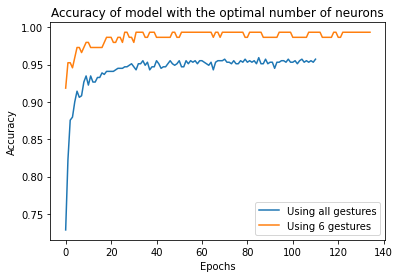

Accuracy is 0.804, using all gestures and neurons set to 512
Accuracy is 0.975, using 6 gestures and neurons set to 256

Model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               12800     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                10260     
Total params: 285,716
Trainable params: 285,716
Non-trainable params: 0
______________________________________________

In [ ]:
best_n_neurons = lnS[accTest.index(max(accTest))]
best_n_neurons6 = lnS[accTest6.index(max(accTest6))]
best_accuracy[5]=max(accTest)
best_accuracy6[5]=max(accTest6)

#Build MLP model with the optimal number of neurons
mlp_model = create_mlp_model(best_n_neurons, 20)
mlp_model6 = create_mlp_model(best_n_neurons6, 6)
train_best_model(mlp_model, mlp_model6, best_n_neurons, best_n_neurons6)

### Convolutional neural network (CNN)

Training for 8 neurons...


2021-10-12 21:56:23.143039: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-10-12 21:56:23.871443: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-12 21:56:23.871791: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-12 21:56:23.871808: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-10-12 21:56:23.872123: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-12 21:56:23.872149: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Accuracy using all gestures: 0.7458 (+/- 0.0412)
Accuracy using 6 gestures: 0.8992 (+/- 0.0627)
Training for 16 neurons...
Accuracy using all gestures: 0.7794 (+/- 0.0299)
Accuracy using 6 gestures: 0.9257 (+/- 0.0454)
Training for 32 neurons...
Accuracy using all gestures: 0.7865 (+/- 0.0239)
Accuracy using 6 gestures: 0.9432 (+/- 0.0458)
Training for 64 neurons...
Accuracy using all gestures: 0.7809 (+/- 0.0327)
Accuracy using 6 gestures: 0.9386 (+/- 0.0421)
Training for 100 neurons...
Accuracy using all gestures: 0.7900 (+/- 0.0251)
Accuracy using 6 gestures: 0.9477 (+/- 0.0405)
Training for 128 neurons...
Accuracy using all gestures: 0.7850 (+/- 0.0174)
Accuracy using 6 gestures: 0.9373 (+/- 0.0322)
Training for 200 neurons...
Accuracy using all gestures: 0.7715 (+/- 0.0348)
Accuracy using 6 gestures: 0.9448 (+/- 0.0241)
Training for 256 neurons...
Accuracy using all gestures: 0.7754 (+/- 0.0407)
Accuracy using 6 gestures: 0.9531 (+/- 0.0317)


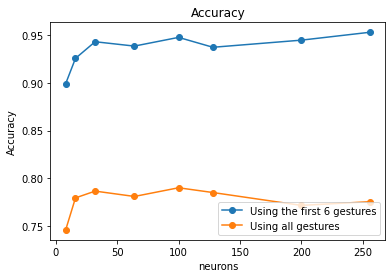

Max accuracy is 0.790, using all gestures and neurons set to 100.
Max accuracy is 0.953, using 6 gestures and neurons set to 256.

In [12]:
from keras.layers import Conv1D, MaxPooling1D, Flatten
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

batch_size=128
accTest, accTest6, lnS = ([] for i in range(3))

def create_cnn_model(ln, output_n_neurons):
    model = Sequential()
    model.add(Conv1D(ln, 2, activation='relu', input_shape=(24, 1)))
    model.add(Conv1D(ln, 2, activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(output_n_neurons, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, 
                  metrics=['accuracy'])
    return model
    
n_params = [8, 16, 32, 64, 100, 128, 200, 256]
accMean, accMean6 = [], []
prepare_data(1)

for p in n_params:
    accTest, accTest6 = [], []
    print("Training for", p, "neurons...")
    
    for r in range(10):
        model = create_cnn_model(p, 20)
        model6 = create_cnn_model(p, 6)
        predict_accuracy(model,model6)
        K.clear_session()

    print("Accuracy using all gestures: %0.4f (+/- %0.4f)" 
              % (np.asarray(accTest).mean(), np.asarray(accTest).std() * 2))
    print("Accuracy using 6 gestures: %0.4f (+/- %0.4f)" 
          % (np.asarray(accTest6).mean(), np.asarray(accTest6).std() * 2))
    accMean.append(np.asarray(accTest).mean())
    accMean6.append(np.asarray(accTest6).mean())
        
accTest, accTest6 = accMean, accMean6
lnS = n_params
print_and_plot_results_neural_network()

Training the model with the optimal number of neurons using all gestures...
Epoch 00116: early stopping
7/7 [==============================] - 0s 1ms/step - loss: 0.7978 - accuracy: 0.7740
Training the model with the optimal number of neurons using 6 gestures....
Epoch 00175: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.1218 - accuracy: 0.9544


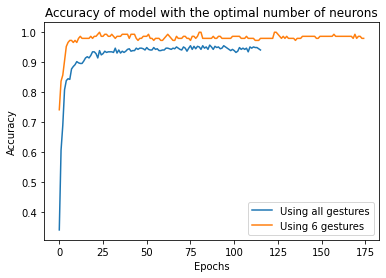

Accuracy is 0.774, using all gestures and neurons set to 100
Accuracy is 0.954, using 6 gestures and neurons set to 256

Model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 100)           300       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 100)           20100     
_________________________________________________________________
dropout (Dropout)            (None, 22, 100)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 100)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1100)              0         
_________________________________________________________________
dense (Dense)                (None, 100)            

In [13]:
best_n_neurons = lnS[accTest.index(max(accTest))]
best_n_neurons6 = lnS[accTest6.index(max(accTest6))]
best_accuracy[6] = max(accTest)
best_accuracy6[6] = max(accTest6)

# Build CNN model with the optimal number of neurons
cnn_model = create_cnn_model(best_n_neurons, 20)
cnn_model6 = create_cnn_model(best_n_neurons6, 6)
train_best_model(cnn_model, cnn_model6, best_n_neurons, best_n_neurons6)


### Recurrent neural networks (RNN) using long-short term memory (LSTM)

Training for 32 neurons...
Accuracy using all gestures: 0.6757 (+/- 0.0297)
Accuracy using 6 gestures: 0.8929 (+/- 0.0675)
Training for 64 neurons...
Accuracy using all gestures: 0.6916 (+/- 0.0139)
Accuracy using 6 gestures: 0.8929 (+/- 0.0206)
Training for 128 neurons...
Accuracy using all gestures: 0.7276 (+/- 0.0165)
Accuracy using 6 gestures: 0.9178 (+/- 0.0462)
Training for 256 neurons...
Accuracy using all gestures: 0.7346 (+/- 0.0154)
Accuracy using 6 gestures: 0.9419 (+/- 0.0302)


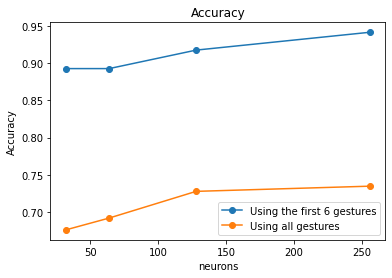

Max accuracy is 0.735, using all gestures and neurons set to 256.
Max accuracy is 0.942, using 6 gestures and neurons set to 256.

In [16]:
from keras.layers import LSTM, Bidirectional

batch_size = 64
accTest, accTest6, lnS = ([] for i in range(3))

def create_lstm_model(ln, output_n_neurons):
    model = Sequential()
    model.add(Bidirectional(LSTM(ln, dropout=0.1), input_shape=(24, 1)))
    model.add(Dense(output_n_neurons, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop', metrics=['accuracy'])
    return model

prepare_data(1)
n_params = [32, 64, 128, 256]
accMean, accMean6 = [], []

for p in n_params:
    accTest, accTest6 = [], []
    print("Training for", p, "neurons...")
    
    for r in range(5):
        model = create_lstm_model(p, 20)
        model6 = create_lstm_model(p, 6)
        predict_accuracy(model,model6)
        K.clear_session()

    print("Accuracy using all gestures: %0.4f (+/- %0.4f)" 
              % (np.asarray(accTest).mean(), np.asarray(accTest).std() * 2))
    print("Accuracy using 6 gestures: %0.4f (+/- %0.4f)" 
          % (np.asarray(accTest6).mean(), np.asarray(accTest6).std() * 2))
    accMean.append(np.asarray(accTest).mean())
    accMean6.append(np.asarray(accTest6).mean())
        
accTest, accTest6 = accMean, accMean6
lnS = n_params
print_and_plot_results_neural_network()

Training the model with the optimal number of neurons using all gestures...
Epoch 00073: early stopping
13/13 [==============================] - 0s 2ms/step - loss: 1.0132 - accuracy: 0.7403
Training the model with the optimal number of neurons using 6 gestures....
Epoch 00158: early stopping
4/4 [==============================] - 0s 2ms/step - loss: 0.0607 - accuracy: 0.9793


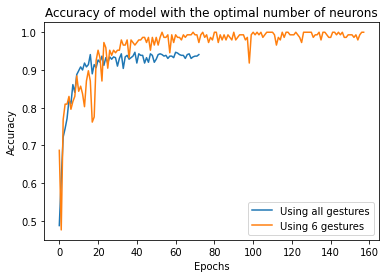

Accuracy is 0.740, using all gestures and neurons set to 256
Accuracy is 0.979, using 6 gestures and neurons set to 256

Model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 512)               528384    
_________________________________________________________________
dense (Dense)                (None, 20)                10260     
Total params: 538,644
Trainable params: 538,644
Non-trainable params: 0
_________________________________________________________________


In [17]:
best_n_neurons = lnS[accTest.index(max(accTest))]
best_n_neurons6 = lnS[accTest6.index(max(accTest6))]
best_accuracy[7]=max(accTest)
best_accuracy6[7]=max(accTest6)

#Build LSTM model with the optimal number of neurons
lstm_model = create_lstm_model(best_n_neurons, 20)
lstm_model6 = create_lstm_model(best_n_neurons6, 6)
train_best_model(lstm_model, lstm_model6, best_n_neurons, best_n_neurons6)

### Print accuracies for every algorithm

In [18]:
algorithms = ['KNN', 'DT', 'RF', 'SVM', 'Sklearn-MLP', 'MLP', 'CNN', 'RNN/LSTM']

for i, (algorithm, accuracy, accuracy6) in enumerate(zip(algorithms, best_accuracy, best_accuracy6)):
    accuracy = format(accuracy*100, '.2f')+'%'
    accuracy6 = format(accuracy6*100, '.2f')+'%'
        
    print('%-16s%-16s%s' % (algorithm, accuracy, accuracy6))

KNN             81.15%          98.34%
DT              58.30%          80.08%
RF              78.40%          98.34%
SVM             75.03%          98.76%
Sklearn-MLP     77.03%          99.17%
MLP             80.11%          96.47%
CNN             79.00%          95.31%
RNN/LSTM        73.46%          94.19%


### Train the best model

In [22]:
# MLP for all the gestures
model = create_mlp_model(512, 20)
history = model.fit(x_tr, y_tr, validation_data=(x_te, y_te), epochs=1000,
                    callbacks=[EarlyStopping(monitor='val_accuracy', patience=200, verbose=0)], 
                    batch_size=128,  verbose=0)
_, test_acc = model.evaluate(x_te, y_te, batch_size=128)
print(test_acc)

7/7 [==============================] - 0s 954us/step - loss: 1.1931 - accuracy: 0.8152
0.8152309656143188


### Save best model as TensorFlow Lite model

In [27]:
import tensorflow as tf

# Write out the Keras save file
keras_file = "model.h5"
keras.models.save_model(model, keras_file)

# Convert the Keras file to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

ValueError: Unable to create dataset (name already exists)